# 9. 선형분류모델

## 9.1 이항 분류 모델

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from CH09 import *

In [3]:
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])
labels = np.array([[0],[0],[0],[1],[1],[1]], dtype=np.int32)
print(xy)
print(labels)

[[0.2  0.4 ]
 [0.4  0.2 ]
 [0.65 0.3 ]
 [0.8  0.5 ]
 [0.5  0.8 ]
 [0.25 0.8 ]]
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]]


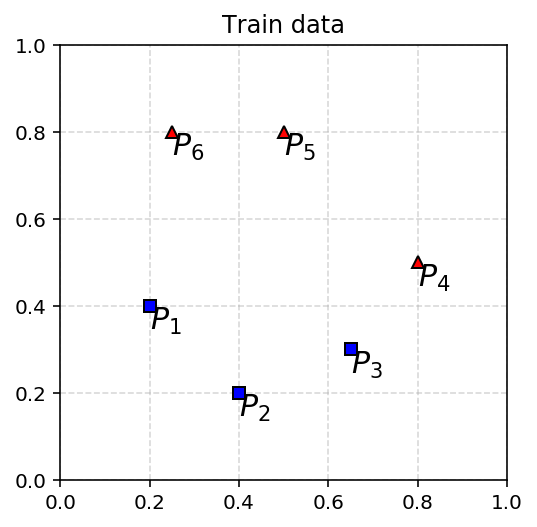

In [4]:
plt.rcParams['figure.figsize'] = (4, 4)
example_plot_wo_contour(xy, labels, 'Train data')

### 9.1.1 연속 확률 모델

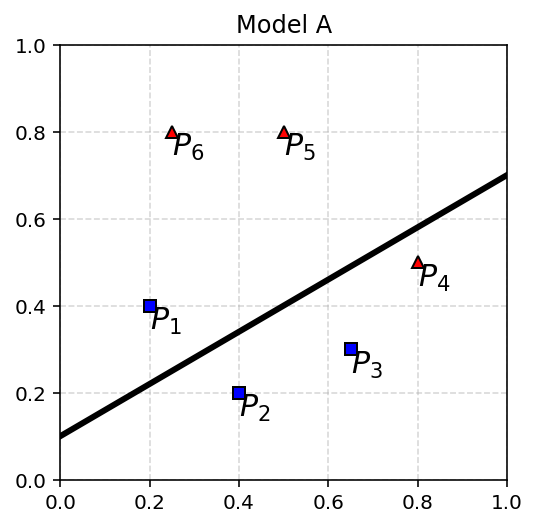

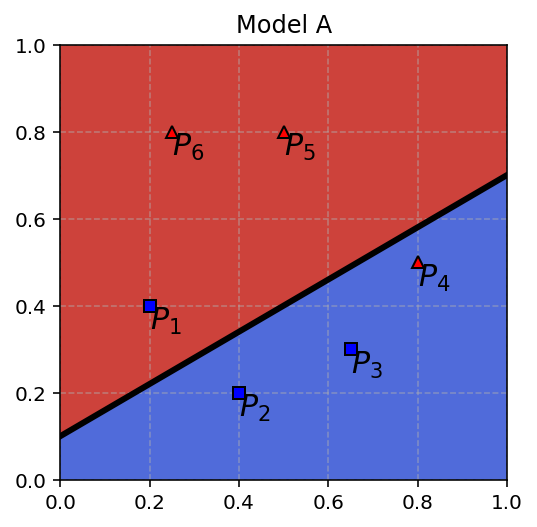

In [5]:
example_plot_only_line(xy, labels, 0.6, .1, 'Model A')
example_plot(xy, labels, 0.6, .1, 'Model A')

In [6]:
# 예측모델 B
W = tf.Variable(np.array([[6],[10]]), dtype=tf.float64)
b = tf.Variable(np.array([-8]), dtype=tf.float64)
x = tf.placeholder(tf.float64, shape=(None, 2))
yhat = tf.nn.sigmoid(tf.matmul(x, W) + b)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

predic = sess.run(yhat, feed_dict={x:xy})
print(predic)
predic[0:3] = 1.0 - predic[0:3]
print(predic)
prob = np.prod(predic)
print(prob)

[[0.05732418]
 [0.02659699]
 [0.24973989]
 [0.85814894]
 [0.95257413]
 [0.81757448]]
[[0.94267582]
 [0.97340301]
 [0.75026011]
 [0.85814894]
 [0.95257413]
 [0.81757448]]
0.46010365197843245


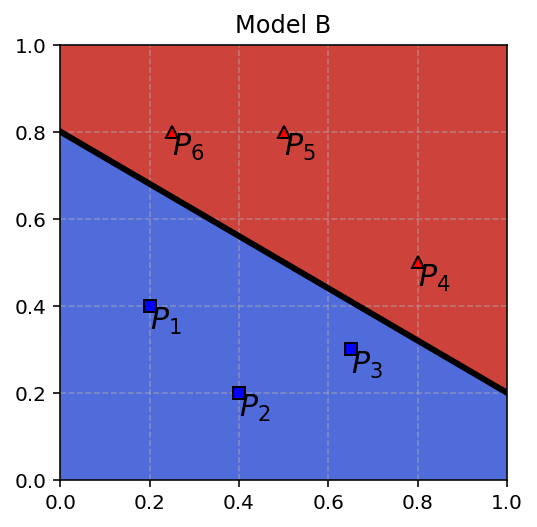

In [7]:
example_plot(xy, labels, -.6, .8, 'Model B')

In [8]:
# 예측모델 C
W = tf.Variable(np.array([[1],[10]]), dtype=tf.float64)
b = tf.Variable(np.array([-5]), dtype=tf.float64)
x = tf.placeholder(tf.float64, shape=(None, 2))
yhat = tf.nn.sigmoid(tf.matmul(x, W) + b)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

predic = sess.run(yhat, feed_dict={x:xy})
print(predic)
predic[0:3] = 1.0 - predic[0:3]
print(predic)
prob = np.prod(predic)
print(prob)

[[0.31002552]
 [0.06913842]
 [0.20587037]
 [0.68997448]
 [0.97068777]
 [0.96267311]]
[[0.68997448]
 [0.93086158]
 [0.79412963]
 [0.68997448]
 [0.97068777]
 [0.96267311]]
0.3288523591939082


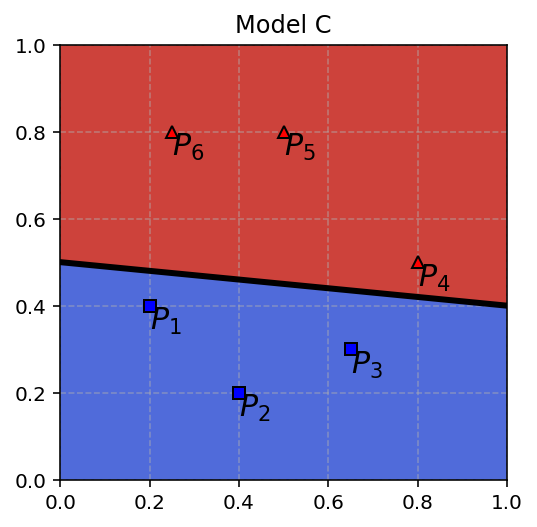

In [9]:
example_plot(xy, labels, -.1, .5, 'Model C')

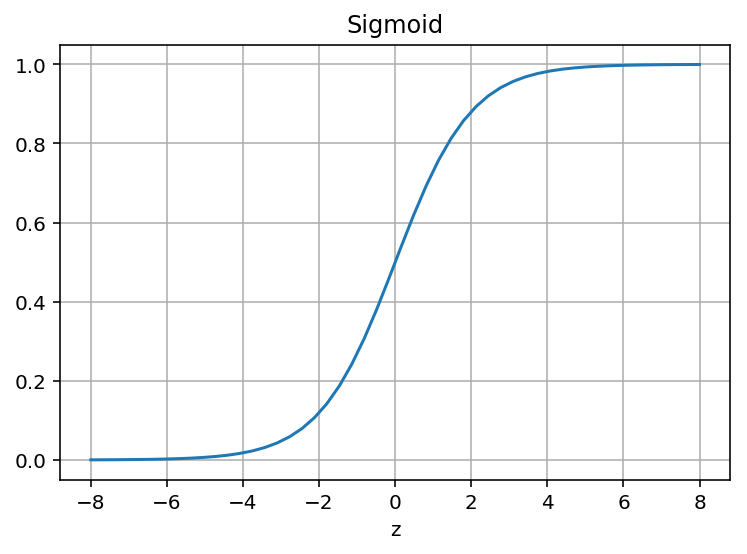

In [10]:
tmp = np.linspace(-8,8)
sigmoid = lambda z:  1.0 / (1+np.exp(-z))

plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(tmp, sigmoid(tmp))
plt.grid()
plt.xlabel('z')
plt.title('Sigmoid')
plt.show()

### 9.1.2 최대우도법과 크로스 엔트로피

In [11]:
# 예측모델 B
W = tf.Variable(np.array([[6],[10]]), dtype=tf.float64)
b = tf.Variable(np.array([-8]), dtype=tf.float64)
x = tf.placeholder(tf.float64, shape=(None, 2))
yhat = tf.nn.sigmoid(tf.matmul(x, W) + b)

# 손실함수
y = tf.placeholder(tf.float64, shape=(None, 1))
loss = tf.reduce_mean(- y * tf.log(yhat) - (1 - y) * tf.log(1-yhat))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

predic, loss_val = sess.run([yhat, loss], feed_dict={x:xy, y:labels})
predic[0:3] = 1.0 - predic[0:3]
prob = np.prod(predic)
print(-np.log(np.prod(predic)), loss_val * len(xy))

0.7763034844941786 0.7763034844941787


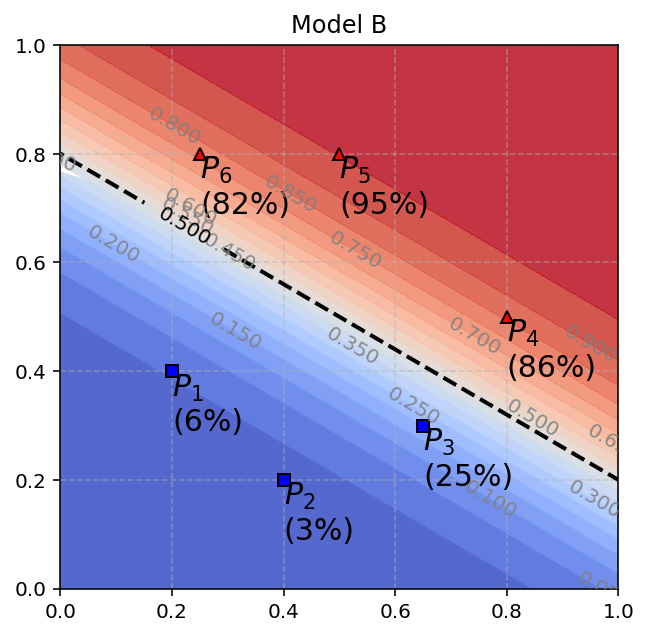

In [12]:
def plot_model(sess, model, feature_labmda, title):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-0.05,1.1,200), np.linspace(-0.05,1.1,200))
    prediction = sess.run(model, feed_dict={x: np.array([feature_labmda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])})
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    cs = ax.contourf(xx, yy, Z, 20, cmap='coolwarm', alpha=.9)
    ax.clabel(cs, colors='gray')
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='k')
        plt.text(x0, y0, '$P_{}$\n({:1.0f}%)'.format(k+1, 100*predictions[k][0]), size=15, \
                 verticalalignment='top', horizontalalignment='left')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(title)
    plt.show()
plot_model(sess, yhat, lambda x,y: [x,y], 'Model B')

### 9.1.3 미니 배치 방법을 통한 모델 학습

In [13]:
# 예측모델과 손실함수
W = tf.Variable(tf.ones([2,1]), tf.float32)
b = tf.Variable(-1.0, tf.float32)

x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 1))

yhat = tf.sigmoid(tf.matmul(x, W) + b)
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat))

features = xy

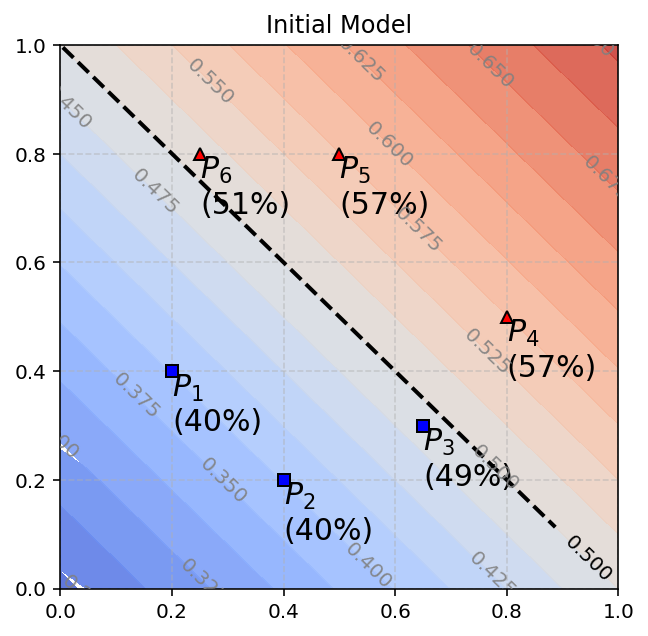

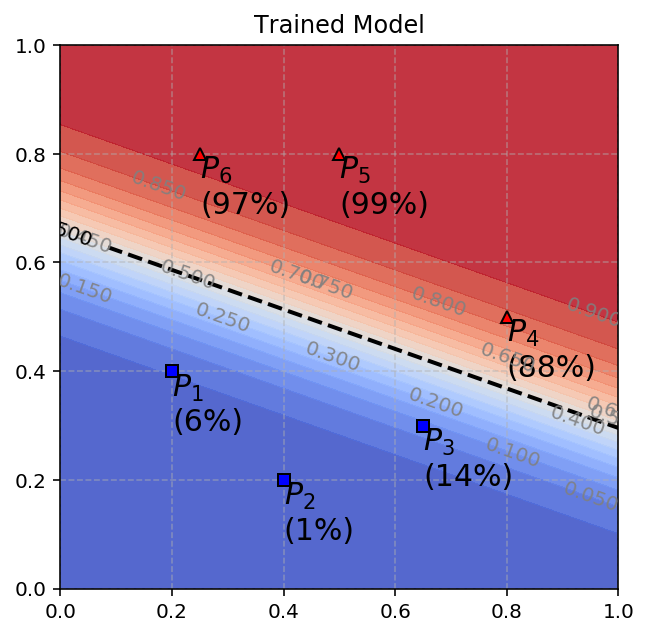

In [14]:
# 수치최적화 알고리즘
MaxEpochs = 50
lr = 1.0
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
# 데이터 섞기
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels[idx]

# 스토캐스틱 방법
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
plot_model(sess, yhat, lambda x,y: [x, y], 'Initial Model')
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch.reshape(-1,1)})
W_sgd, b_sgd = sess.run([W, b])

plot_model(sess, yhat, lambda x,y: [x,y], 'Trained Model')

### 9.1.4 특성값을 이용한 비선형 분류 모델

In [15]:
from sklearn.datasets import make_circles
xy, labels = make_circles(n_samples=400, noise=0.1)

In [16]:
# 특성값 정의
features = np.array([[xval**2, yval**2] for xval, yval in xy])

In [17]:
# 예측모델과 손실함수
W = tf.Variable(tf.ones([2,1]), tf.float32)
b = tf.Variable(-1/4, tf.float32)

x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 1))

yhat = tf.sigmoid(tf.matmul(x, W) + b)
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat))

In [18]:
def plot_model(sess, model, feature_labmda, title):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.5,1.5, 200), np.linspace(-1.5,1.5, 200))
    prediction = sess.run(model, feed_dict={x: np.array([feature_labmda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])})
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    colors = {0:'red', 1:'blue'}
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    ax.contourf(xx, yy, Z, 5, cmap='coolwarm', alpha=.9)
#     ax.clabel(cs, colors='k')
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    grouped = df.groupby('label')
#     for key, group in grouped:
#         group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], edgecolor='k')
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k]], mec='k', alpha=0.6)
    ax.set_xlim([-1.3, 1.3])
    ax.set_ylim([-1.3, 1.3])
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

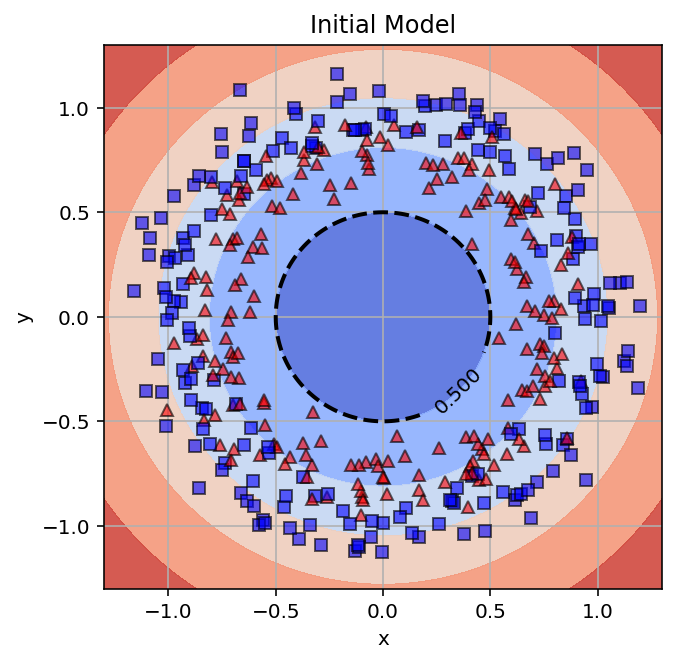

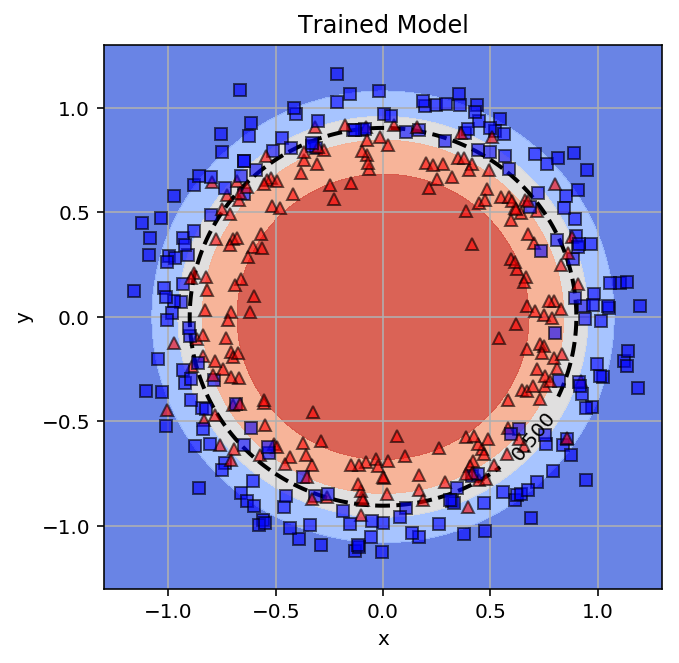

In [19]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# 수치최적화 알고리즘
MaxEpochs = 50
lr = 0.01
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
# 데이터 섞기
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels[idx]

# 스토캐스틱 방법
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
plot_model(sess, yhat, lambda x,y: [x**2, y**2], 'Initial Model')
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch.reshape(-1,1)})
W_sgd, b_sgd = sess.run([W, b])

plot_model(sess, yhat, lambda x,y: [x**2, y**2], 'Trained Model')

In [20]:
plt.rcParams['figure.figsize'] = (16./3, 9./3)
def plot_scatter_softmax(curr_W, curr_b, xy, labels):
    x1 = np.linspace(-0.1, 1.1)
    X, Y = np.meshgrid(x1,x1)
    Z1 = X * curr_W[0,0] + Y * curr_W[1,0] + curr_b[0]
    Z2 = X * curr_W[0,1] + Y * curr_W[1,1] + curr_b[1]
    Z = np.exp(Z1) / (np.exp(Z1) + np.exp(Z2))
    markers = ['bs', 'r^']
    plt.figure(figsize=(5,5))
    cs = plt.contourf(X, Y, Z, np.linspace(0, 1, 11), cmap='coolwarm')
    plt.clabel(cs, colors='k')
    for k, xy0 in enumerate(xy):
        x0, y0 = xy0
        z1 = x0 * curr_W[0,0] + y0 * curr_W[1,0] + curr_b[0]
        z2 = x0 * curr_W[0,1] + y0 * curr_W[1,1] + curr_b[1]
        z = np.array([z1,z2])
        softmax_z = np.exp(z) / np.sum(np.exp(z))
        plt.plot(x0, y0, markers[labels[k][0]], mec='k')
        plt.text(x0, y0, '$P_{}$\n({:1.1f},{:1.1f})'.format(k+1, softmax_z[0], softmax_z[1]), size=15, \
                 verticalalignment='top', horizontalalignment='left')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

## 9.2 다중 분류 모델

### 9.2.2 원-핫(One-hot) 인코딩

In [21]:
np.random.seed(402)
xy = np.array([[.2, .4], [.4, .2], [.65,.3],\
               [.8, .5], [.5, .8], [.25, .8]])
# 특성값 정의
features = np.array([[xval, yval] for xval, yval in xy])
features[:5]

labels = np.array([[0, 1],[0, 1],[0, 1],[1, 0],[1, 0],[1, 0]])
# Notice one-hot encoding
print(labels)

[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]]


### 9.2.3 다중 분류 모델의 크로스 엔트로피

In [22]:
# 예측모델과 손실함수
x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 2))

W = tf.Variable(tf.ones([2, 2]), dtype=tf.float32)
b = tf.Variable(tf.ones([2]), dtype=tf.float32)

yhat = tf.nn.softmax(tf.matmul(x, W) + b)
loss = tf.reduce_mean(tf.reduce_sum(-y * tf.log(yhat), 1))

### 9.2.4 미니 배치 방법을 통한 모델 학습

In [23]:
# 수치최적화 알고리즘
MaxEpochs= 25
lr = 0.5
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels[idx]

# 스토캐스틱 방법
from helper import generate_batches
batch_size = 5
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpochs):
        if epoch % 10 == 0 :
            curr_b, curr_W, curr_loss = sess.run([b, W, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
            print(epoch, curr_b.flatten(), curr_W.flatten(), curr_loss)
#             plot_scatter_softmax(curr_W, curr_b, xy, labels)
        for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})

    curr_b_sgd, curr_W_sgd = sess.run([b, W])

0 [1. 1.] [1. 1. 1. 1.] 0.6931472
10 [-0.21212184  2.2121224 ] [ 0.62501156  1.374989    4.78899    -2.7889895 ] 0.34730077
20 [-1.5397967  3.5397968] [ 1.4501979   0.54980254  6.390087   -4.390086  ] 0.18532221


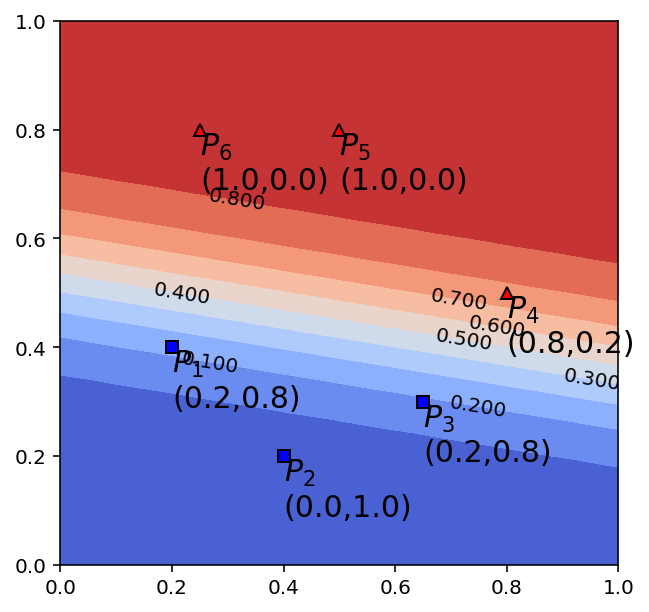

In [23]:
plot_scatter_softmax(curr_W_sgd, curr_b_sgd, xy, labels)

### 9.2.5 MNIST

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [25]:
from collections import Counter
freq = Counter([np.argmax(label) for label in mnist.train.labels])
for k in range(0,10):
    print("label {0} : {1}개".format(k, freq[k]))

label 0 : 5444개
label 1 : 6179개
label 2 : 5470개
label 3 : 5638개
label 4 : 5307개
label 5 : 4987개
label 6 : 5417개
label 7 : 5715개
label 8 : 5389개
label 9 : 5454개


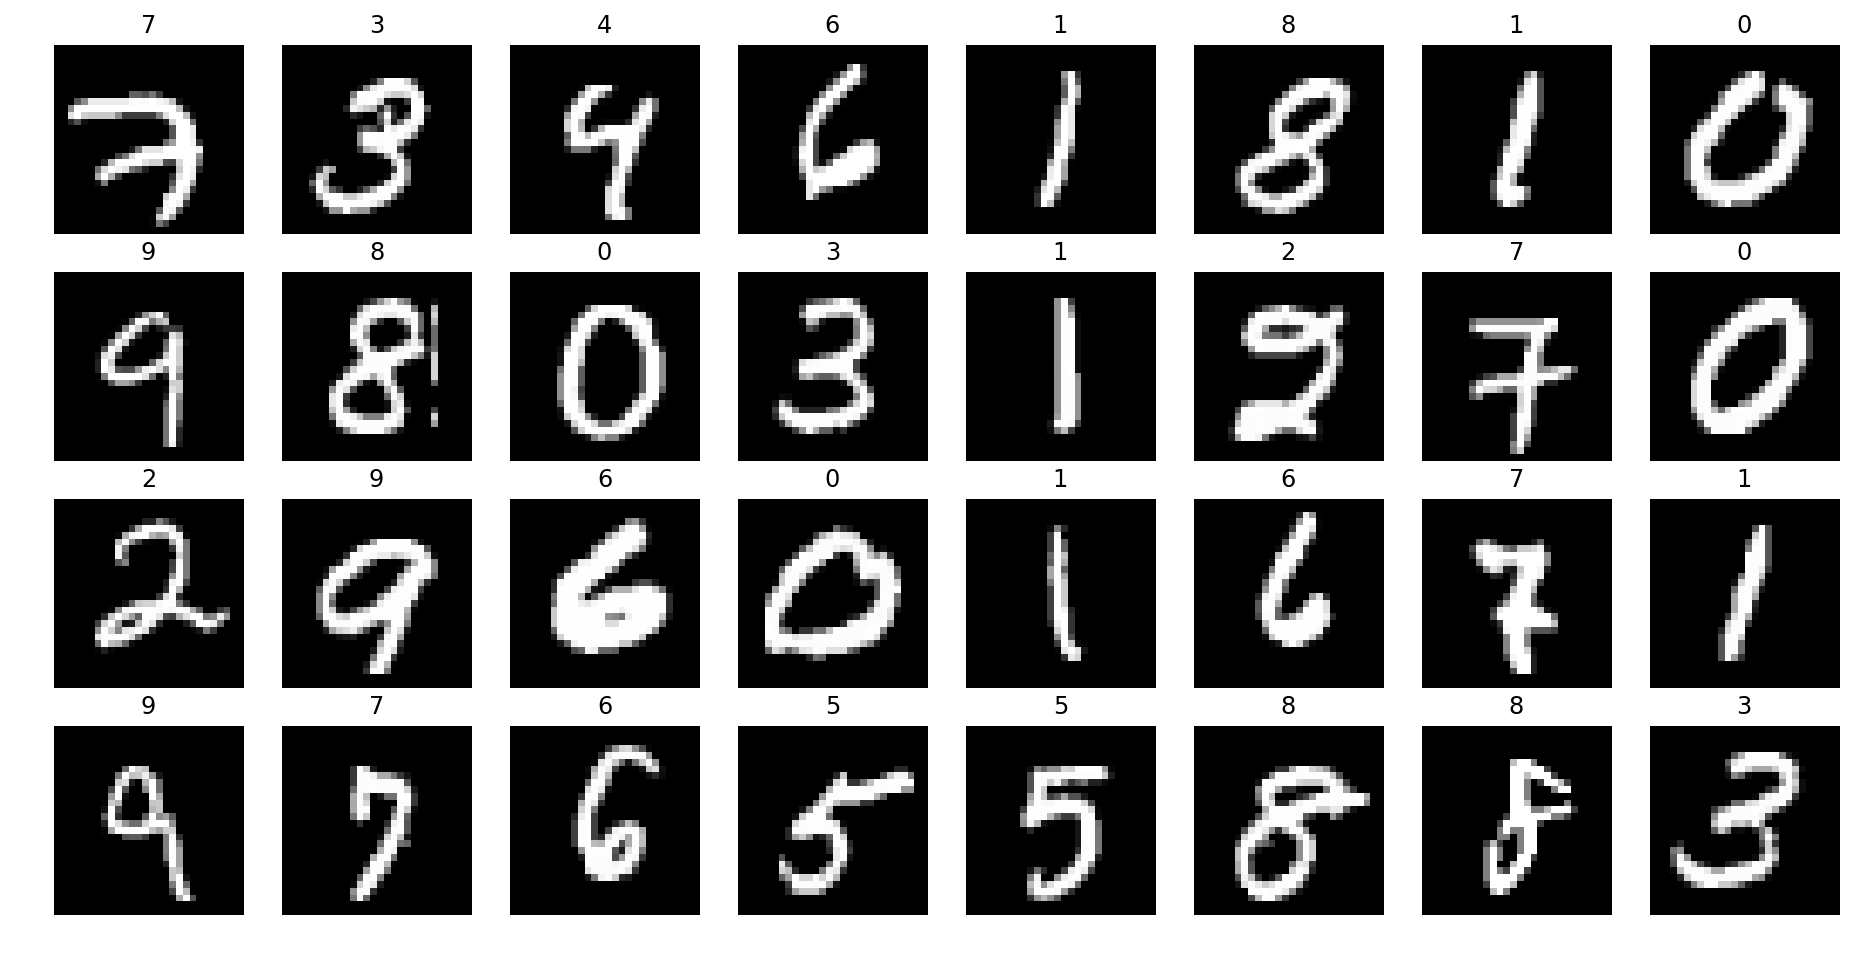

In [26]:
plt.figure(figsize=(16,8))
for k in range(32):
    img = mnist.train.images[k].reshape(28,28)
    label = np.argmax(mnist.train.labels[k])
    plt.subplot(4,8,1+k)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(label)
plt.show()

In [27]:
features = mnist.train.images
labels = mnist.train.labels

In [28]:
# 예측모델
x = tf.placeholder(tf.float32, [None, 784])

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
yhat = tf.nn.softmax(tf.matmul(x, W) + b)

In [29]:
# 손실함수
y = tf.placeholder(tf.float32, [None, 10])
loss = tf.reduce_mean(tf.reduce_sum(-y * tf.log(yhat), 1))

In [30]:
# 수치최적화 알고리즘
MaxEpochs = 1
lr = 0.01
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 정확도
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(yhat,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [31]:
# 스토캐스틱 방법
batch_size = 256
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(MaxEpochs):
    for step in range(len(mnist.train.images) // batch_size + 1):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(train, feed_dict={x:batch_xs, y:batch_ys})
        if step % 20 == 0:
            curr_W, curr_b, curr_loss = sess.run([W, b, loss], feed_dict={x:features, y:labels})
            curr_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels})
            print(epoch, step, curr_loss, curr_acc)
    print("")

0 0 1.9595028 0.4651
0 20 0.48387116 0.8713
0 40 0.39446467 0.894
0 60 0.37069795 0.8943
0 80 0.3392461 0.9078
0 100 0.32434994 0.9151
0 120 0.3171351 0.9172
0 140 0.310502 0.917
0 160 0.29950166 0.9187
0 180 0.29637212 0.9196
0 200 0.30557847 0.9124



In [32]:
test_id = 9229
test_image = mnist.test.images[test_id]
test_label = mnist.test.labels[test_id]

out = sess.run(yhat, feed_dict={x:[test_image]})
print("Predicted Label : {0} (Real Label : {1})".format(np.argmax(out), np.argmax(test_label)))

Predicted Label : 3 (Real Label : 3)
